## Image segmentation using Unet model

### Dataset handling

#### Pycocotools demo. See this to understand what it can do for our task.

MSCOCO is pretty big, and more so we need a way to handle the input images, classIDs, Class Names and the segment positions. 
<br>Released in 2022, pycocotools is a fork of the original cocoapi and can do precisely that.
<br>Let's demo it's capabilities.

##### Objective 1: Show the library where the MSCOCO data is

Note: The images selected **will** have all the categories in them. So you have to select a sensible amount of categories to filter.<br>
Because too many categories selected will mean less images selected.

In [104]:
from pycocotools.coco import COCO
import skimage.io as io
import cv2
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(47)


# Control knobs
DATA_DIR = 'Data/' 
DATASET_TYPE = 'train'
DATASET_VERSION = '2014' # For demo, I've used 2014 images, but I want to try latter versions as well.
DATASET_DIR = DATA_DIR+'annotations/instances_{}{}.json'.format(DATASET_TYPE,DATASET_VERSION)
# You can get these from the 'just_the_names' variable. These were picked from the 2014 dataset.

# Modify as you see fit.
ALLOWED_CATEGORIES = ['cell phone','laptop','person']

print(DATASET_DIR)

Data/annotations/instances_train2014.json


In [105]:
# Get COCO library the dataset.
coco = COCO(DATASET_DIR)

loading annotations into memory...
Done (t=65.81s)
creating index...
index created!


##### Objective 2: Detect the supercategories and categories.

In [106]:
# Get the categoryIDs and their respective names
category_ids = coco.getCatIds(catNms = ALLOWED_CATEGORIES) # Just the IDs. 
category_names = coco.loadCats(category_ids) # This is a list of dictionaries. Contains the category and which supercategory they belong to. Will also have the ID.

print(type(category_ids), len(category_ids),'\n',type(category_names), len(category_names))
print(category_ids[:5])
print(category_names[:5]) 

<class 'list'> 3 
 <class 'list'> 3
[1, 73, 77]
[{'supercategory': 'person', 'id': 1, 'name': 'person'}, {'supercategory': 'electronic', 'id': 73, 'name': 'laptop'}, {'supercategory': 'electronic', 'id': 77, 'name': 'cell phone'}]


In [107]:
# Remove the catNms argument above for this block to make sense. 
# Basically we want to see all the categories available to us.
# Don't forger to add it back for the remainder of this project.
just_the_names = sorted([item['name'] for item in category_names])
just_the_names[:5]

['cell phone', 'laptop', 'person']

##### Objective 3: Display an image from the dataset

Step 1: Get the ID<br>
Step 2: Get the associated image metadata<br>
Step 3: Fetch the image location from the metadata<br>
Step 4: Load image into variable / Display.

In [108]:
# Get the image ids from the allowed categories.
# If I supply all categories, it won't return anything.
image_ids = coco.getImgIds(catIds=category_ids)
# load one image ID, randomly. we index 0 since it's a list of dictionaries.
image = coco.loadImgs(image_ids[np.random.randint(0,len(image_ids))])[0]

# Let's see how many images do we have that we can play with
print(len(image_ids))

# And what each image contains.
image

240


{'license': 1,
 'file_name': 'COCO_train2014_000000238860.jpg',
 'coco_url': 'http://images.cocodataset.org/train2014/COCO_train2014_000000238860.jpg',
 'height': 480,
 'width': 640,
 'date_captured': '2013-11-24 03:00:07',
 'flickr_url': 'http://farm5.staticflickr.com/4114/4876643196_133cb3d45a_z.jpg',
 'id': 238860}

So each image extracted is more like metadata containing the features relevant to us like:<br>
1. file_name : The name of the file which we will use to extract from our downloaded data. Otherwise we'd use the coco_url to download each one.
2. height & width : Will give us specifications on what the image size is, in case we have to resize it.
3. id : Unique identifier for the image

(-0.5, 639.5, 479.5, -0.5)

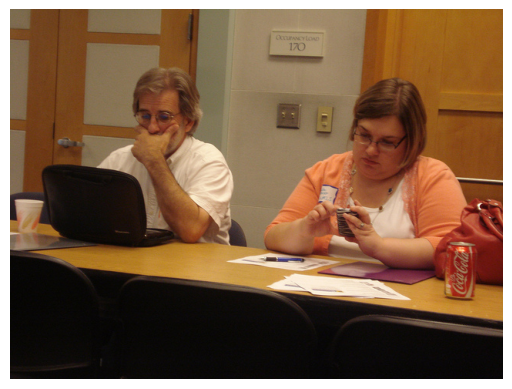

In [123]:
image_location = DATA_DIR+'/images/{}{}/{}'.format(DATASET_TYPE,DATASET_VERSION,image['file_name'])
output_image = io.imread(image_location)/255.0
plt.imshow(output_image);plt.axis('off')

##### Objective 4: Display it's corresponding segments

Step 1: Get the associated image ID<br>
Step 2: Get the associated categories to mark<br>
Step 3: Load the annoatations into variable<br>
Step 4: Plot image.<br>
Step 5: Show annotation locations on image

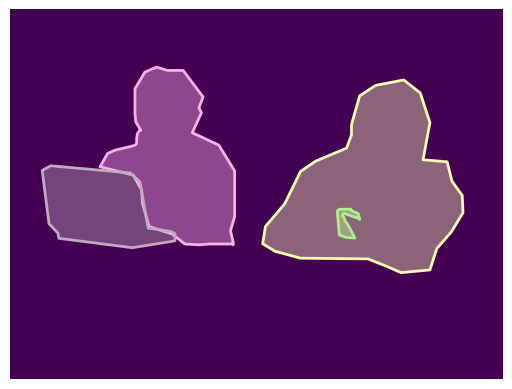

In [178]:
# Show the mask
annotations_ids = coco.getAnnIds(imgIds=image['id'], catIds=category_ids, iscrowd=None)
annotations = coco.loadAnns(annotations_ids)
mask = np.zeros(output_image.shape[:-1])
plt.imshow(mask);plt.axis('off')
coco.showAnns(annotations)


In [111]:
# What does it look like?
annotations

[{'segmentation': [[442.14,
    258.95,
    427.04,
    259.12,
    424.55,
    261.44,
    427.21,
    292.49,
    436.17,
    295.64,
    447.46,
    296.47,
    438.16,
    278.87,
    434.01,
    273.56,
    434.18,
    271.07,
    431.19,
    267.25,
    433.18,
    264.27,
    439.32,
    266.42,
    452.77,
    271.24,
    453.6,
    272.4,
    451.77,
    264.93,
    448.12,
    263.1,
    442.64,
    260.78]],
  'area': 553.1458500000003,
  'iscrowd': 0,
  'image_id': 238860,
  'bbox': [424.55, 258.95, 29.05, 37.52],
  'category_id': 77,
  'id': 323817},
 {'segmentation': [[289.08,
    305.26,
    289.08,
    300.94,
    285.84,
    286.92,
    291.24,
    268.58,
    291.24,
    242.7,
    291.24,
    209.26,
    270.74,
    175.82,
    236.22,
    159.64,
    248.09,
    133.75,
    244.85,
    127.28,
    250.25,
    113.26,
    224.36,
    78.74,
    206.02,
    78.74,
    203.87,
    78.74,
    189.84,
    74.43,
    174.74,
    80.9,
    161.8,
    102.47,
    161.8,
   

It's a list of dictionaries with the segment bounding box and the category id.

#### Imports and global variables

In [ ]:
from pycocotools.coco import COCO
import skimage.io as io
import cv2
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(47)


# Control knobs
DATA_DIR = 'Data/' 
DATASET_TYPE = 'train'
DATASET_VERSION = '2014' # For demo, I've used 2014 images, but I want to try latter versions as well.
DATASET_DIR = DATA_DIR+'annotations/instances_{}{}.json'.format(DATASET_TYPE,DATASET_VERSION)
IMAGE_SHAPE = (256,256)

# You would want your model to identify these categories.
# Don't select all, you won't get images that have all categories at once.
# I'm going for indoor use, so cell phone, laptop and person.
ALLOWED_CATEGORIES = ['cell phone','laptop','person']

print(DATASET_DIR)

coco = COCO(DATASET_DIR)

#### Function to generate the ground truths and corresponding mask.

In [229]:
def image_and_mask_generator(coco, image_size = (256,256), categories = ALLOWED_CATEGORIES, data_dir = DATA_DIR, dataset_type = DATASET_TYPE, dataset_version = DATASET_VERSION):
    """
    This function is used to take the MSCOCO dataset and the pycocotools library and generate one image and it's mask (depending on categories selected) as a tuple.

    """
    
    # Fetch category IDs. This is the first step to filter the dataset of images we have.
    category_ids = coco.getCatIds(catNms = ALLOWED_CATEGORIES) # Just the IDs. 
    category_names = coco.loadCats(category_ids) # This is a list of dictionaries. Contains the category and which supercategory they belong to. Will also have the ID.
    
    # Init the directory where we have our images stored.
    images_directory = DATA_DIR+'/images/{}{}/'.format(DATASET_TYPE,DATASET_VERSION)

    # Get the image Ids we're gonna work with.
    image_ids = coco.getImgIds(catIds=category_ids)
    

    for i in range(len(image_ids)):
        # Pick the image to work with
        image = coco.loadImgs(image_ids[i])[0]

        # Read the image file and normalize it.
        output_image = io.imread(images_directory +image['file_name'])/255
        
        # Get the ids that we're working with in the image and load them.
        annotations_ids = coco.getAnnIds(imgIds=image['id'], catIds=category_ids, iscrowd=None)
        annotations = coco.loadAnns(annotations_ids)
        

        # Create the mask
        # We will first create a blank mask
        mask = np.zeros(output_image.shape[:-1]) # We do not resize here since we've to calculate the pixel values for the original size.
        # For each annotation found, draw it's relevant mask into our blank mask.
        for i in range(len(annotations)):
            # Get the category ID of that annotation mask.
            pixel_value = annotations[i]['category_id']
            # Put the pixel value as the mask ID.
            mask = np.maximum(coco.annToMask(annotations[i]) * pixel_value, mask)

        # Now resize it for training the model.
        final_output_image = cv2.resize(output_image,image_size)
        final_output_mask = cv2.resize(mask,image_size)
        
        yield final_output_image, final_output_mask


len(z)